# Plotting jets as images

In [1]:
import time
from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
import coffea.processor as processor
from awkward import JaggedArray
import numpy as np
import glob as glob
import itertools
import json
import uproot_methods
import copy
from coord_transform import *
import tensorflow as tf
import pandas as pd

In [2]:
def pseudorapidity(theta):
    return -np.log(np.tan(theta*0.5))

In [3]:
def dataStream(output):
    image = output['flippedImages'].value
    pt = output['jetPt'].value
    eta = output['jetEta'].value
    phi = output['jetPhi'].value
    labels = output['label'].value
    np.savez('/mnt/data/ml/ShowJetsData', jetImages = image, pt = pt, eta = eta, phi = phi, labels = labels)
    dataset = tf.data.Dataset.from_tensor_slices((labels, pt, eta, phi, image))
    return dataset

In [4]:
def transform_to_softdrop_axes(jetparticles,Jets):
    
    subjet0leading = (Jets.subjet0_pt > Jets.subjet1_pt)
    centroid1_pt = np.where( subjet0leading, Jets.subjet0_pt, Jets.subjet1_pt  )
    centroid1_eta = np.where( subjet0leading, Jets.subjet0_eta, Jets.subjet1_eta  )
    centroid1_phi = np.where( subjet0leading, Jets.subjet0_phi, Jets.subjet1_phi  )
    centroid1_m = np.where( subjet0leading, Jets.subjet0_m, Jets.subjet1_m  )
    centroid2_pt = np.where( subjet0leading, Jets.subjet1_pt, Jets.subjet0_pt,   )
    centroid2_eta = np.where( subjet0leading, Jets.subjet1_eta, Jets.subjet0_eta  )
    centroid2_phi = np.where( subjet0leading, Jets.subjet1_phi, Jets.subjet0_phi  )
    centroid2_m = np.where( subjet0leading, Jets.subjet1_m, Jets.subjet0_m  )
    pcentroid1 = uproot_methods.TLorentzVectorArray.from_ptetaphim( centroid1_pt, centroid1_eta, centroid1_phi, centroid1_m )
    pcentroid2 = uproot_methods.TLorentzVectorArray.from_ptetaphim( centroid2_pt, centroid2_eta, centroid2_phi, centroid2_m )
    
    #distance between the two centroids
    r0 = pcentroid1.delta_r(pcentroid2)
    
    centroid1 = uproot_methods.TVector3Array.from_cartesian(pcentroid1.x, pcentroid1.y, pcentroid1.z)
    centroid2 = uproot_methods.TVector3Array.from_cartesian(pcentroid2.x, pcentroid2.y, pcentroid2.z)
    particle_p3s = uproot_methods.TVector3Array.from_cartesian(jetparticles.p4.x, jetparticles.p4.y, jetparticles.p4.z)
    
    # Rotate coordinate system so "centroid1" is along the x axis
    rot1_axis, rot1_angle = coord_rotation( centroid1, uproot_methods.TVector3(1,0,0) )    
    centroid1 = centroid1.rotate_axis(rot1_axis, rot1_angle)
    centroid2 = centroid2.rotate_axis(rot1_axis, rot1_angle)
    particle_p3s = particle_p3s.rotate_axis(rot1_axis, rot1_angle)

    # Rotate about the z axis so that centroid2 is pointing down
    rot2_angle = -np.arctan2( centroid2.z, centroid2.y )
    centroid2 = centroid2.rotatex(rot2_angle)
    particle_p3s = particle_p3s.rotatex(rot2_angle)
    
    # Scale the image so that centroid2 is at (0,1,0)
    deta = np.divide(pseudorapidity(particle_p3s.theta),r0)
    dphi = np.divide(particle_p3s.phi,r0)
        
    return deta,dphi,centroid1,centroid2

In [5]:
# Look at ProcessorABC to see the expected methods and what they are supposed to do
class JetImageProcessor(processor.ProcessorABC):
    def __init__(self):
        self.eta_bins = 16
        self.phi_bins = 16
        dataset_axis = hist.Cat("dataset", "Primary dataset")
        event_axis = hist.Bin("event", "Event number", 10000, 0, 10000 )
        pdgid_axis = hist.Bin("pdgid", r"PDG ID", 10000, -5000, 5000)
        eta_axis = hist.Bin("eta", r"$\eta$", 32, -5, 5)
        phi_axis = hist.Bin("phi", r"$\phi$", 32, -np.pi, np.pi)
        image_dphi = hist.Bin("image_dphi", r"$Q_1$", self.phi_bins, -2, 2) #yaxis
        image_deta = hist.Bin("image_deta", r"$Q_2$", self.eta_bins, -2, 2) #xaxis
        pt_axis = hist.Bin("pt", r"$p_{T}$ [GeV]", 1000, 0, 5000)
        m_axis = hist.Bin("m", r"$p_{T}$ [GeV]", 200, 0, 500)
        dr_axis = hist.Bin("dr", r"$\Delta r$", 80, 0, 0.8)
        
        self._accumulator = processor.dict_accumulator({
            'pt':hist.Hist("Counts", dataset_axis, pt_axis),
            'eta':hist.Hist("Counts", dataset_axis, eta_axis),
            'flippedImages': processor.column_accumulator(np.zeros(shape=(0,16,16))),
            'jetEta': processor.column_accumulator(np.zeros(shape=(0))),
            'jetPhi': processor.column_accumulator(np.zeros(shape=(0))),
            'jetPt': processor.column_accumulator(np.zeros(shape=(0))),
            'label': processor.column_accumulator(np.zeros(shape=(0))),
            'image':hist.Hist(r"$p_{T}$", dataset_axis, event_axis, image_dphi, image_deta),
            'dr':hist.Hist("Counts", dataset_axis, dr_axis),
            'pdgid':hist.Hist("Counts", dataset_axis, pdgid_axis),
            'cutflow': processor.defaultdict_accumulator(int)
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()

        
        dataset = df['dataset']
        evnum = df['eventNum']
        
        Jets = JaggedCandidateArray.candidatesfromcounts(
            df['nJet'],
            pt=df['jet_pt'],
            eta=df['jet_eta'],
            phi=df['jet_phi'],
            mass=df['jet_m'],
            msd=df['jet_msd'],
            subjet0_pt=df['jet_subjet0_pt'],
            subjet0_eta=df['jet_subjet0_eta'],
            subjet0_phi=df['jet_subjet0_phi'],
            subjet0_m=df['jet_subjet0_m'],
            subjet1_pt=df['jet_subjet1_pt'],
            subjet1_eta=df['jet_subjet1_eta'],
            subjet1_phi=df['jet_subjet1_phi'],
            subjet1_m=df['jet_subjet1_m'],
            ic=df['jet_ic']
            )        
        constituents = JaggedCandidateArray.candidatesfromcounts(
            df['nConstituent'],
            pt=df['constituent_pt'],
            eta=df['constituent_eta'],
            phi=df['constituent_phi'],
            mass=df['constituent_m'],
            pdgid=df['constituent_id']
            )
        deta,dphi,centroid1,centroid2= transform_to_softdrop_axes(constituents, Jets[:,0])        
        constituents.add_attributes( deta=deta )
        constituents.add_attributes( dphi=dphi )
        
        constituents = constituents[constituents.pt > 1]
        
        Jets = Jets[Jets.pt > 200]
        oneJet = (Jets.counts >=1)
        Jets = Jets[oneJet]
        constituents = constituents[oneJet]
        validImages = np.zeros(int(np.max(evnum)+1), dtype=bool)
        evnum = evnum[oneJet]
        validImages[evnum] = True
                
        dr = Jets[:,0].p4.delta_r(constituents.p4)
        jetconstituents = constituents[dr < 0.8]
        jetconstituents = jetconstituents
        
        deta = jetconstituents.deta
        dphi = jetconstituents.dphi
        
        eventReshaped = JaggedArray.fromoffsets( jetconstituents.offsets, np.ones(deta.flatten().shape[0]))
        eventReshaped = eventReshaped * evnum
        
        # Performing parity flip so that sum(right) is higher than sum(left) for each image
        eventbins = np.arange(len(validImages)+1)
        xbins= np.linspace(-2,2,num=self.eta_bins+1)
        ybins= np.linspace(-2,2,num=self.phi_bins+1)
        
        H_images = np.histogramdd((eventReshaped.flatten(),dphi.flatten(),deta.flatten()),
                    bins=(eventbins ,ybins, xbins), weights = jetconstituents.pt.flatten())[0]
        H_images = H_images[validImages]
        mask = (np.sum(H_images[:,:,:int(self.eta_bins/2)], axis = (1,2)) < np.sum(H_images[:,:,int(self.eta_bins/2):], axis = (1,2)))
        sign = np.where(mask, 1, -1)
        deta = (sign*deta)
        H_images_new = np.histogramdd((eventReshaped.flatten(),dphi.flatten(),deta.flatten()),
                    bins=(eventbins ,ybins, xbins), weights = jetconstituents.pt.flatten())[0]

        if ("Zprime" in dataset):
            labels = np.ones([len(deta)])
        else:
            labels = np.zeros([len(deta)])
        
        output['pt'].fill(dataset=dataset,
                          pt=Jets.pt[:,0].flatten())
        output['eta'].fill(dataset=dataset,
                           eta=Jets.eta[:,0].flatten())
        output['flippedImages'] += processor.column_accumulator(H_images_new[validImages])
        output['jetPt'] += processor.column_accumulator(Jets.pt[:,0].flatten())
        output['jetEta'] += processor.column_accumulator(Jets.eta[:,0].flatten())
        output['jetPhi'] += processor.column_accumulator(Jets.phi[:,0].flatten())
        output['label'] += processor.column_accumulator(labels)
        output['image'].fill(dataset=dataset,
                            event=eventReshaped.flatten(), 
                            image_deta=deta.flatten(),
                            image_dphi=dphi.flatten(),
                            weight=jetconstituents.pt.flatten())
        output['dr'].fill(dataset=dataset,
                          dr=dr.flatten())
        output['pdgid'].fill(dataset=dataset,
                             pdgid=jetconstituents.pdgid.flatten())
        
        return output

    def postprocess(self, accumulator):
        return accumulator

In [6]:
fileset={
     'Zprime1TeV':['/mnt/data/ml/gravkk_zz_1TeV_addevnum.root'],
     'Zprime2TeV':['/mnt/data/ml/gravkk_zz_2TeV_addevnum.root'],
     'Zprime3TeV':['/mnt/data/ml/gravkk_zz_3TeV_addevnum.root'],
#     'QCD':['/mnt/data/ml/qcd_flat15to7000_addevnum.root']
}
tstart = time.time() 
output = processor.run_uproot_job(fileset,
                                  treename='T',
                                  processor_instance=JetImageProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args={'workers':4, 'flatten': True},
                                  chunksize=5000)
elapsed = time.time() - tstart
# print(output)

In [7]:
parameters = list(output)
print(parameters)
batched_dataset = dataStream(output)
print(batched_dataset)

['pt', 'eta', 'flippedImages', 'jetEta', 'jetPhi', 'jetPt', 'label', 'image', 'dr', 'pdgid', 'cutflow']
<TensorSliceDataset shapes: ((), (), (), (), (16, 16)), types: (tf.float64, tf.float64, tf.float64, tf.float64, tf.float64)>


In [8]:
traindata = np.load('/mnt/data/ml/ShowJetsData.npz')
print(traindata['jetImages'].shape)

(286606, 16, 16)


In [9]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

Figure(432x288)


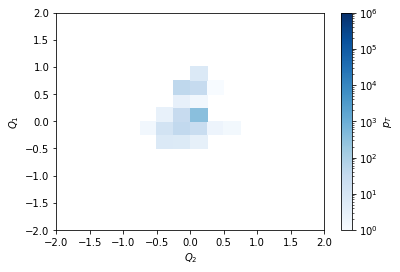

In [10]:
fig, ax, grid = hist.plot2d(output['image'].integrate('dataset', 'Zprime1TeV').integrate("event",922),xaxis='image_deta', patch_opts={'norm':LogNorm(vmin=1, vmax=1e6),'cmap':'Blues'})
print(fig)
fig.savefig("Zprime1TeV_eventImage_vectorised.png")

Figure(432x288)


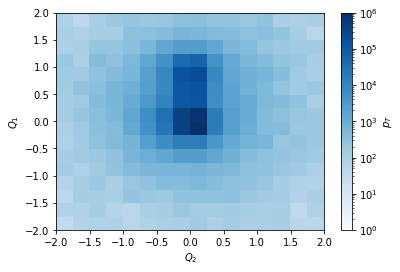

In [11]:
fig, ax, grid = hist.plot2d(output['image'].integrate('dataset', 'Zprime1TeV').integrate("event"),xaxis='image_deta', patch_opts={'norm':LogNorm(vmin=1, vmax=1e6),'cmap':'Blues'})
print(fig)
fig.savefig("Zprime1TeV_image_vectorised.png")

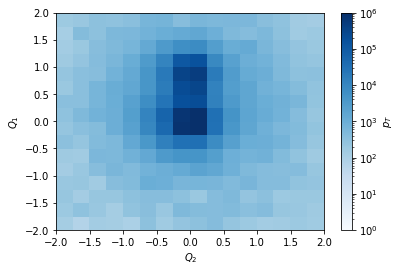

In [12]:
fig, ax, grid = hist.plot2d(output['image'].integrate('dataset', 'Zprime2TeV').integrate("event"),xaxis='image_deta', patch_opts={'norm':LogNorm(vmin=1, vmax=1e6),'cmap':'Blues'})

fig.savefig("Zprime2TeV_image.png")

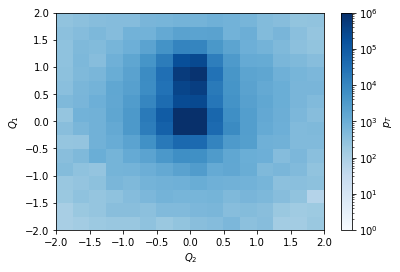

In [13]:
fig, ax, grid = hist.plot2d(output['image'].integrate('dataset', 'Zprime3TeV').integrate("event"),xaxis='image_deta', patch_opts={'norm':LogNorm(vmin=1, vmax=1e6),'cmap':'Blues'})

fig.savefig("Zprime3TeV_image.png")

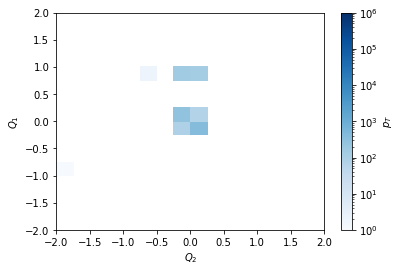

In [14]:
fig, ax, grid = hist.plot2d(output['image'].integrate('dataset', 'Zprime3TeV').integrate("event",1)
                            ,xaxis='image_deta', patch_opts={'norm':LogNorm(vmin=1, vmax=1e6),'cmap':'Blues'})

fig.savefig("Zprime3TeV_eventImage.png")

In [15]:
# fig, ax, grid = hist.plot2d(output['image'].integrate('dataset', 'QCD'),xaxis='image_deta', patch_opts={'norm':LogNorm(vmin=1, vmax=1e6),'cmap':'Blues'})

# fig.savefig("QCD_image.png")

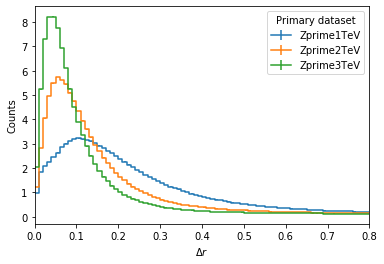

In [16]:
fig, ax = hist.plotgrid(output['dr'], overlay="dataset", stack=False, density=True
                                 )
for iax in ax.flatten():
    iax.autoscale(axis='y')
fig.show()
fig.savefig("dr_plot.png")

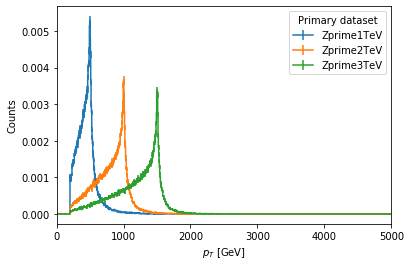

In [17]:
fig, ax = hist.plotgrid(output['pt'], overlay="dataset", stack=False, density=True
                                 )
for iax in ax.flatten():
    iax.autoscale(axis='y')
fig.show()
fig.savefig("pt_plot.png")

In [18]:
# image1 = np.array((output['image']['Zprime1TeV'].values()).get(('Zprime1TeV',)))
# print(image1.shape)
# n=0
# for i in image1.sum(axis = (2,1)):
#     if i > 0:
#         n +=1
# print('Number of non-zero images = ',n)
# im2 = plt.imshow(np.sum(image1, axis=(0)), interpolation='nearest', origin='low', norm=LogNorm(), cmap='Blues')
# plt.colorbar()
# plt.show()
# print("Sum of all pixels: ", np.sum(image1))